In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.core import MadMiner
from madminer.plotting import plot_2d_morphing_basis
from madminer.delphes import DelphesProcessor
from madminer.sampling import combine_and_shuffle
from madminer.sampling import SampleAugmenter
from madminer.sampling import constant_benchmark_theta, multiple_benchmark_thetas
from madminer.sampling import constant_morphing_theta, multiple_morphing_thetas, random_morphing_thetas
from madminer.ml import MLForge


## 6. Make (unweighted) training and test samples with augmented data

Here you can either load the parton or reco level data:
- parton level: load `'data/madminer_example_shuffled_parton.h5'`
- reco level: load `'data/madminer_example_shuffled_reco.h5'`

select with the flag below:

In [2]:
use_parton_level = True

The next step is handled by the `madminer.sampling` class `SampleAugmenter`. From all the data we have in the MadMiner file now, it extracts unweighted samples including the augmented data ("gold") that is needed as training and evaluation data for the machine learning algorithms.

In [3]:
if use_parton_level:
    sa = SampleAugmenter('data/madminer_example_shuffled_parton.h5')
else:
    sa = SampleAugmenter('data/madminer_example_shuffled_reco.h5')

The `SampleAugmenter` class defines five different high-level functions to generate train or test samples:
- `extract_samples_train_plain()`, which only saves observations x, for instance for histograms or ABC;
- `extract_samples_train_local()` for methods like SALLY and SALLINO, which will be demonstrated in the second part of the tutorial;
- `extract_samples_train_ratio()` for techniques like CARL, ROLR, CASCAL, and RASCAL, when only theta0 is parameterized;
- `extract_samples_train_more_ratios()` for the same techniques, but with both theta0 and theta1 parameterized;
- `extract_samples_test()` for the evaluation of any method.

For the arguments `theta`, `theta0`, or `theta1`, you can use the helper functions `constant_benchmark_theta()`, `multiple_benchmark_thetas()`, `constant_morphing_theta()`, `multiple_morphing_thetas()`, and `random_morphing_thetas()`, all defined in the `madminer.sampling` module.

Here we'll train a likelihood ratio estimator with the RASCAL method, so we focus on the `extract_samples_train_ratio()` function.

In [4]:
x, theta0, theta1, y, r_xz, t_xz = sa.extract_samples_train_ratio(
    theta0=random_morphing_thetas(100, [('flat', 0., 1.)]),
    theta1=constant_benchmark_theta('sm'),
    n_samples=100000,
    folder='./data/samples',
    filename='train1'
)

9534 negative weights (0.19068)
36 negative weights (0.00072)
557 negative weights (0.01114)
479 negative weights (0.00958)
3480 negative weights (0.0696)
11663 negative weights (0.23326)
335 negative weights (0.0067)
12621 negative weights (0.25242)
12267 negative weights (0.24534)
19 negative weights (0.00038)
239 negative weights (0.00478)
1752 negative weights (0.03504)
131 negative weights (0.00262)
3405 negative weights (0.0681)
90 negative weights (0.0018)
12286 negative weights (0.24572)
2 negative weights (4e-05)
7922 negative weights (0.15844)
10942 negative weights (0.21884)
5008 negative weights (0.10016)
5 negative weights (0.0001)
12911 negative weights (0.25822)
6894 negative weights (0.13788)
47 negative weights (0.00094)
12905 negative weights (0.2581)
6827 negative weights (0.13654)
20 negative weights (0.0004)
4241 negative weights (0.08482)
1878 negative weights (0.03756)
9609 negative weights (0.19218)
12214 negative weights (0.24428)
3 negative weights (6e-05)
10 

For the evaluation we'll need a test sample, and we'll make three: at the SM, at purely CP odd, and one for the intermediate morphing parameter:

In [5]:
x, theta = sa.extract_samples_test(
    theta=constant_benchmark_theta('sm'),
    n_samples=10000,
    folder='./data/samples',
    filename='test'
)

x_bsm, theta_bsm = sa.extract_samples_test(
    theta=constant_benchmark_theta('w'),
    n_samples=10000,
    folder='./data/samples',
    filename='test_bsm'
)

x_bsm_morph, theta_bsm_morph = sa.extract_samples_test(
    theta=constant_benchmark_theta('morphing_basis_vector_2'),
    n_samples=10000,
    folder='./data/samples',
    filename='test_bsm_morph'
)

Let's have a look at some distributions and correlations between these two samples:

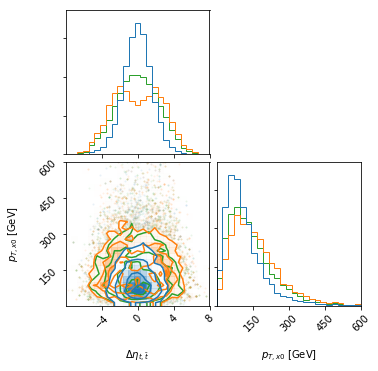

In [6]:
import corner

if use_parton_level: # parton level analysis
    labels = [r'$\Delta\eta_{t,\bar{t}}$', r'$p_{T, x0}$ [GeV]']
    ranges = [(-8., 8.), (0., 600.)]
    bins   = (25,25)
else:
    labels = [r'$\Delta \phi_{\gamma \gamma}$', r'$p_{T, \gamma \gamma}$']
    bins   = (25,25)
    ranges = [(-3.15, 3.15), (0., 600.)]

fig = corner.corner(x_bsm_morph, color='C2', labels=labels, range=ranges, bins=bins)
_ = corner.corner(x_bsm, color='C1', labels=labels, range=ranges, bins=bins, fig=fig)
_ = corner.corner(x, color='C0', labels=labels, range=ranges, bins=bins, fig=fig)

# blue is SM, orange is CP-odd, green is mixture

We can also calculate total cross sections:

In [7]:
thetas_benchmarks, xsecs_benchmarks, xsec_errors_benchmarks = sa.extract_cross_sections(
    theta=multiple_benchmark_thetas(['sm', 'w', 'morphing_basis_vector_2'])
)

thetas_morphing, xsecs_morphing, xsec_errors_morphing = sa.extract_cross_sections(
    theta=random_morphing_thetas(1000, [('flat', 0., 1.)])
)

In [8]:
print("benchmark x-secs")
bench_names = ['sm', 'w', 'morphing_basis_vector_2']
for ibench, bench in enumerate(xsecs_benchmarks):
    print(bench_names[ibench], bench)


benchmark x-secs
sm 2.11901419999939
w 0.3060352305378751
morphing_basis_vector_2 0.5838223908189969


### Warning:
The code below needs to be updated for the x-sec plots (right now it is set up for 2d plots)

In [10]:
'''cmin, cmax = np.mean(xsecs_morphing) - 2 * np.std(xsecs_morphing), np.mean(xsecs_morphing) + 2 * np.std(xsecs_morphing)

fig = plt.figure(figsize=(5,4))

sc = plt.scatter(thetas_morphing[:,0], thetas_morphing[:,1], c=xsecs_morphing,
            s=40., cmap='viridis', vmin=cmin, vmax=cmax,
            marker='o')

plt.scatter(thetas_benchmarks[:,0], thetas_benchmarks[:,1], c=xsecs_benchmarks,
            s=200., cmap='viridis', vmin=cmin, vmax=cmax, lw=2., edgecolor='black',
            marker='s')

print("benchmark x-secs")
bench_names = ['sm', 'w', 'morphing_basis_vector_2']
for ibench, bench in enumerate(xsecs_benchmarks):
    print(bench_names[ibench], bench)
cb = plt.colorbar(sc)
cb.set_label('xsec [pb]')

plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.tight_layout()
plt.show()''';

What  you see here is a morphing algorithm in action. We only asked MadGraph to calculate event weights (differential cross sections, or basically squared matrix elements) at six fixed parameter points (shown here as squares with black edges). But with our knowledge about the structure of the process we can interpolate any observable to any parameter point without loss (except that statistical uncertainties might increase)!